<a href="https://colab.research.google.com/github/harim061/FakeNewsDetection/blob/main/GramMatrix/GramFakeImg2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
import os
from google.colab import files
from google.colab import drive
import shutil

In [ ]:
!pip install kaggle

In [ ]:
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ciplab/real-and-fake-face-detection

100% 431M/431M [00:23<00:00, 21.3MB/s]
100% 431M/431M [00:23<00:00, 19.3MB/s]


In [ ]:
from zipfile import ZipFile
file_name = 'real-and-fake-face-detection.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall('/content/kaggle/input/')

In [ ]:
def gram_matrix(input):
    # 배치크기, 특징 맵의 수, (c,d) 특징 맵의 차원
    a, b, c, d = input.size() # a:[배치크기], b:512, c:1, d:1

    # 모든 특징 맵을 2d 탠서로 평면화
    features = input.view(a, b, c * d) # [배치크기, 512, 1]

    # Gram matrix 계산
    G = torch.bmm(features, features.transpose(1, 2))
    G = G.div(b * c * d) # [배치크기, 512, 512]
    return G

In [ ]:
class FakeImgDetector(nn.Module):
  def __init__(self):
    super(FakeImgDetector, self).__init__()
    self.resnet = models.resnet18(pretrained=True)

     # 첫 계층 ~ 마지막 분류 계층 전까지 분류
    self.features = nn.Sequential(*list(self.resnet.children())[:-1])
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))


    # 그램 매트릭스 계산 후, 분류기로 사용될 FC 계층
    self.fc1 = nn.Linear(512*512, 256) # 중간 계층 추가
    self.fc2 = nn.Linear(256, 2)  # 마지막 분류 계층

  def forward(self, x):

    # 이미지 특징 맵 출력
    x = self.features(x) # [배치크기, 512, 7, 7]
    x = self.avgpool(x)  # [배치크기, 512, 1, 1]
    # 그램 매트릭스 계산
    x = gram_matrix(x) # [배치크기, 512, 512]
    x = x.view(x.size(0), -1) # [배치크기, 512*512]
    x = torch.relu(self.fc1(x))  # ReLU 활성화 함수 적용 [배치크기, 256]
    x = self.fc2(x) # [배치크기, 2]
    return x


In [ ]:
# 데이터 로딩 데이터 전처리 및 증강
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,244)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(True),
    transforms.RandomVerticalFlip(False),
])

In [ ]:
dataset = datasets.ImageFolder(root='/content/kaggle/input/real_and_fake_face_detection/real_and_fake_face',transform=transform)

In [ ]:
total_size = len(dataset)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size


train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=18, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=18, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=18, shuffle=False)

In [ ]:
# 모델 훈련


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FakeImgDetector().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



# 모델 훈련
for epoch in range(15):
    model.train()  # 모델을 훈련 모드로 설정
    train_loss = 0.0
    correct_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100. * correct_train / len(train_dataset)

    # 검증 단계 추가
    model.eval()  # 모델을 평가 모드로 설정
    correct_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct_test += predicted.eq(labels).sum().item()

    test_acc = 100. * correct_test / len(test_dataset)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')


Epoch: 1, Train Loss: 0.7026, Train Acc: 52.24%, Test Acc: 62.44%
Epoch: 2, Train Loss: 0.6773, Train Acc: 57.63%, Test Acc: 63.41%
Epoch: 3, Train Loss: 0.6468, Train Acc: 63.52%, Test Acc: 55.61%
Epoch: 4, Train Loss: 0.6334, Train Acc: 66.67%, Test Acc: 60.49%
Epoch: 5, Train Loss: 0.5845, Train Acc: 69.75%, Test Acc: 64.88%
Epoch: 6, Train Loss: 0.5631, Train Acc: 71.15%, Test Acc: 60.00%
Epoch: 7, Train Loss: 0.5123, Train Acc: 76.26%, Test Acc: 61.95%
Epoch: 8, Train Loss: 0.4713, Train Acc: 78.22%, Test Acc: 60.98%
Epoch: 9, Train Loss: 0.3880, Train Acc: 82.91%, Test Acc: 65.37%
Epoch: 10, Train Loss: 0.3326, Train Acc: 85.99%, Test Acc: 61.95%
Epoch: 11, Train Loss: 0.2904, Train Acc: 88.59%, Test Acc: 56.10%
Epoch: 12, Train Loss: 0.2078, Train Acc: 92.86%, Test Acc: 62.93%
Epoch: 13, Train Loss: 0.1679, Train Acc: 93.35%, Test Acc: 60.98%
Epoch: 14, Train Loss: 0.1467, Train Acc: 94.54%, Test Acc: 61.46%
Epoch: 15, Train Loss: 0.1008, Train Acc: 96.29%, Test Acc: 64.88%


In [ ]:
# 모델 가중치 저장하기

model_save_path = "fake_img_detector1.pth"
torch.save(model.state_dict(), model_save_path)

In [ ]:
drive.mount('/content/drive')
shutil.copy('fake_img_detector1.pth', '/content/drive/My Drive/fake_img_detector1.pth')

Mounted at /content/drive


'/content/drive/My Drive/fake_img_detector1.pth'

In [ ]:
# 1. 모델 아키텍처 생성
model = FakeImgDetector()

# 2. 저장된 가중치 불러오기
model.load_state_dict(torch.load("fake_img_detector1.pth"))

# 3. 모델을 평가 모드로 전환 (예: 추론/검증/테스트를 수행할 경우)
model.eval()

FakeImgDetector(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
import PIL.Image as Image
import matplotlib.pyplot as plt

def predict_image(image_path, model, transform):
    model = model.to(device)
    # 이미지 로드
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.show()
    # 이미지 전처리
    image_tensor = transform(image).unsqueeze(0).to(device)

    # 모델 예측
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)

    return "Fake" if predicted.item() == 0 else "Real"

# 모델 로드
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

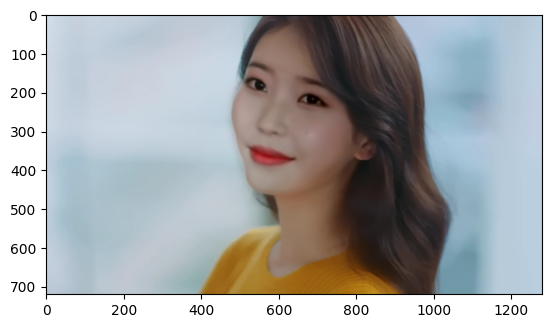

The image is: Real


In [ ]:
image_path =  '/content/deepfake.png'
prediction = predict_image(image_path, model, transform)
print(f"The image is: {prediction}")

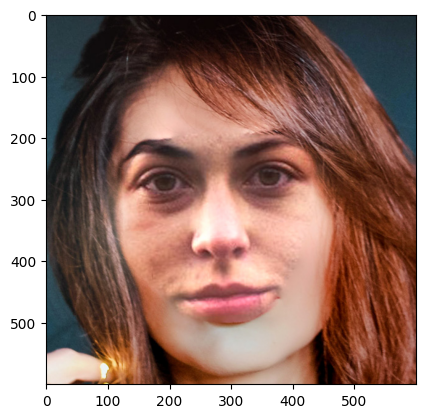

The image is: Fake


In [ ]:
image_path =  '/content/easy_16_1111.jpg'
prediction = predict_image(image_path, model, transform)
print(f"The image is: {prediction}")